In [2]:
import numpy as np
import matplotlib.pyplot as plt

import pickle
import sys

from tqdm import tqdm_notebook

from nltk import ngrams

In [3]:
import itertools
from itertools import tee

import editdistance as ed

In [4]:
def plot_gr(gr, start=0, end=-1, log = False, all_ticks = False,  s=10):
    plt.figure(figsize=(s,s))
    if end == -1:
        end = gr.shape[0]
    if log:
        plt.imshow(np.log(gr[start:end,start:end] + 1))
    else:
        plt.imshow(gr[start:end,start:end])
    plt.colorbar()
    if all_ticks: 
        plt.xticks(np.arange(start,end))
        plt.yticks(np.arange(start,end))
    plt.show()

In [5]:
def plot_group(*args, s = 7):
    n = len(args) // 2
    
    plt.figure(figsize=(s,s))
    f, a = plt.subplots(1, n,figsize=(s,s))
    #f.set_figsize((s,s))
    for i in range(n):
        im = args[2*i]
        if args[2*i + 1]:
            im = np.log(im + 1)
        a[i].imshow(im)

    plt.show()

In [6]:
# Check randint
def generate_repeat(repeat_a, repeat_b):
    transition_pos = np.random.randint(0, len(repeat_a) + 1)
    return repeat_a[0:transition_pos] + repeat_b[transition_pos:]

In [7]:
class RepeatsDescr:
    def __init__(self, repeats):
        self.n = len(repeats)
        self.repeats = repeats
        self.repeat_to_n = dict(zip(self.repeats, np.arange(len(repeats))))
        self.n_to_repeat = dict(zip(np.arange(len(repeats)), self.repeats))
        self.mat = self._create_complementory_matrix()

    def add_repeat(self, repeat):
        self.repeats.append(repeat)
        self.repeat_to_n[repeat] = self.n
        self.n_to_repeat[self.n] = repeat
        self.n += 1
        self._update_complementory_matrix()
        
    def _create_complementory_matrix(self):
        mat = np.zeros((self.n, self.n))

        for r1, r2 in itertools.product(self.repeats, self.repeats):
            mat[self.repeat_to_n[r1]][self.repeat_to_n[r2]] = 1 - (ed.eval(r1,r2) / max(len(r1), len(r2)))
        return mat
    
    def _update_complementory_matrix(self):
        self.mat = np.pad(self.mat, ((0,1), (0,1)), mode = 'constant')
        
        for r in self.repeats:
            val = 1 - (ed.eval(r,repeats[-1]) / max(len(r), len(repeats[-1])))
            self.mat[self.repeat_to_n[r], self.repeat_to_n[repeats[-1]]] = val
            self.mat[self.repeat_to_n[repeats[-1]], self.repeat_to_n[r]] = val

In [8]:
repeats = ['aaaaaaaaaa',
           'aaaaaaaaab',
           'aaaaaaaabb']

repeats_descr = RepeatsDescr(repeats)

In [9]:
repeats_descr.add_repeat("aaaaaaabbb")

In [792]:
class Population:
    def __init__(self,
                 initial_population, 
                 primers_counts,
                 max_len = 10):
        self.max_len = max_len
        self.max_size = (sum(primers_counts.values()) + len(initial_population))
        
        self.p = np.ones((self.max_size, self.max_len)).astype(int) * -1
        
        pos = 0
        for arr in initial_population:
            self.p[pos, (max_len - len(arr)) // 2: (max_len - len(arr)) // 2 + len(arr)] = arr
            pos += 1
        for k, v in primers_counts.items():
            self.p[pos: pos + v, max_len // 2 ] = k
            pos += v
        
        self.glue_mask = self.p[:, ::2].flatten() != -1
        
        if V == 'DEBUG' or V == 'DEBUG_1':
            print(self.p, "\n")   
            
    
    def get_rep_pos_by_ind(self, ind):
        return (ind * 2 // self.p.shape[1], ind * 2 % self.p.shape[1])
    
    
    def get_rep_by_ind(self, ind):
        return self.p[:,::2].flatten()[ind]

    def _recalc_glue_mask(self):
        self.glue_mask = self.p[:, ::2].flatten() != -1

In [793]:
from copy import deepcopy

In [884]:
class PCR:
    def __init__(self, population, repeats_descr):
        self.fp = population
        self.bp = deepcopy(population)
#         self.ni = population.p.shape[0]
#         self.nj = population.p.shape[1]
        
        self.comp_mat = np.zeros((self.fp.glue_mask.shape[0], self.fp.glue_mask.shape[0]))
        
        for i in np.where(self.fp.glue_mask)[0]:
            for j in np.where(self.bp.glue_mask)[0]:
                self.comp_mat[i][j] = repeats_descr.mat[self.fp.get_rep_by_ind(i), self.fp.get_rep_by_ind(j)]
                
    def _annealing(self):
        self.anneal_all = (np.random.random(size = self.comp_mat.shape) < self.comp_mat).astype(int)
        self.anneal = np.zeros_like(self.comp_mat)
        #indexes = np.arange(self.anneal_all.shape[0])[self.anneal_all.sum(1) != 0]
        #np.random.shuffle(indexes)
        indexes = np.arange(self.anneal_all.shape[0])
        np.random.shuffle(indexes)
        
        for i in indexes:
            row = self.anneal_all[i]
            if row.sum() != 0:
                j = np.random.choice(np.arange(self.comp_mat.shape[0]), size = 1, p = row.astype(float) / row.sum())

                if np.random.random() < 0.5 * self.anneal_all[i, j]:
                    self.anneal[i, j] = 1
                    self.anneal[j, i] = 1

                self.anneal_all[i] = 0
                self.anneal_all[:, i] = 0
                self.anneal_all[j] = 0
                self.anneal_all[:, j] = 0
            
            
    def _amplify(self):
        
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            print(f, b, '; ', fi, fj, '; ', bi, bj)
            
            self.glue_f_to_b(fi, fj, bi, bj)
            self.glue_b_to_f(fi, fj, bi, bj)
            
            
    def glue_f_to_b(self, fi, fj, bi, bj):
        if self.fp.p[fi][fj + 1] == -1 and fj + 2 != self.fp.max_len:
            copy_part = self.bp.p[bi][bj:][self.bp.p[bi][bj:] != -1][: self.fp.max_len - fj]
            self.fp.p[fi][fj:fj + copy_part.shape[0]] = copy_part
    
    
    def glue_b_to_f(self, fi, fj, bi, bj):
        if bj > 0 and self.bp.p[bi][bj - 1] == -1:
            copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj - 1:fj]
            self.bp.p[bi][bj - copy_part.shape[0]:bj] = copy_part
            
            
    def print_glue_points(self):
        for f, b in zip(np.where(self.anneal == 1)[0], np.where(self.anneal == 1)[1]):
            fi, fj = self.fp.get_rep_pos_by_ind(f)
            bi, bj = self.bp.get_rep_pos_by_ind(b)
            print(f, b, '; ', fi, fj, '; ', bi, bj)
            
    
    def cycle(self):
        self._annealing()
        self._amplify()
        self.fp, self.bp = self.bp, self.fp
    
    def to_pairs(self):
        all_pairs = {}
        for product in np.vstack((self.fp.p[:, ::2],self.bp.p[:, ::2])):
            for a,b in zip(product, product[1:]):
                if a!= -1 and b!= -1:
                    if (a,b) in all_pairs:
                        all_pairs[(a,b)] += 1
                    else:
                        all_pairs[(a,b)] = 1
        return all_pairs
    
    def to_graph(self, sp_num):
        gr = np.zeros((sp_num, sp_num))
        
        for p, n in self.to_pairs().items():
            gr[p[0]][p[1]] = n
        return gr
        

In [885]:
V = 'DEBUG_2'

In [886]:
p_list = [[0,0, 0,1, 0,2, 0,3, 0,4, 0], [0,1, 0,5, 0,6,0]]
primers_num = {0:100}
p = Population(p_list, primers_num, max_len=16)

In [887]:
p.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [888]:
p.p[-2:]

array([[-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [889]:
pcr = PCR(p, repeats_descr)

In [890]:
pcr.fp.p

array([[-1, -1,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [895]:
pcr.bp.p[:10]

array([[-1,  4,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0,  4,  0, -1],
       [-1,  1,  0,  2,  0,  1,  0,  5,  0,  6,  0,  6,  0,  4,  0, -1],
       [-1, -1, -1, -1, -1, -1, -1,  5,  0,  5,  0,  6,  0, -1, -1, -1],
       [-1, -1, -1,  1,  0,  5,  0,  6,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  0,  0,  0,  1,  0,  5,  0,  6,  0, -1],
       [-1, -1, -1, -1, -1, -1, -1,  0,  0,  1,  0,  2,  0,  3,  0,  4],
       [-1, -1, -1, -1, -1, -1, -1,  3,  0,  6,  0,  6,  0,  4,  0, -1],
       [-1, -1, -1, -1, -1, -1, -1,  4,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  2,  0,  0,  0,  1,  0,  2,  0,  3],
       [-1,  1,  0,  2,  0,  3,  0,  4,  0,  0,  0,  1,  0,  2,  0,  3]])

In [892]:
for i in range(40):
    pcr.cycle()

2 36 ;  0 4 ;  4 8
4 164 ;  0 8 ;  20 8
5 13 ;  0 10 ;  1 10
6 796 ;  0 12 ;  99 8
11 452 ;  1 6 ;  56 8
13 5 ;  1 10 ;  0 10
36 2 ;  4 8 ;  0 4
44 692 ;  5 8 ;  86 8
76 788 ;  9 8 ;  98 8
84 372 ;  10 8 ;  46 8
108 532 ;  13 8 ;  66 8
140 252 ;  17 8 ;  31 8
156 284 ;  19 8 ;  35 8
164 4 ;  20 8 ;  0 8
188 804 ;  23 8 ;  100 8
212 212 ;  26 8 ;  26 8
228 548 ;  28 8 ;  68 8
252 140 ;  31 8 ;  17 8
260 468 ;  32 8 ;  58 8
276 356 ;  34 8 ;  44 8
284 156 ;  35 8 ;  19 8
324 772 ;  40 8 ;  96 8
356 276 ;  44 8 ;  34 8
372 84 ;  46 8 ;  10 8
380 620 ;  47 8 ;  77 8
396 556 ;  49 8 ;  69 8
404 780 ;  50 8 ;  97 8
412 428 ;  51 8 ;  53 8
428 412 ;  53 8 ;  51 8
452 11 ;  56 8 ;  1 6
468 260 ;  58 8 ;  32 8
484 484 ;  60 8 ;  60 8
492 508 ;  61 8 ;  63 8
500 612 ;  62 8 ;  76 8
508 492 ;  63 8 ;  61 8
532 108 ;  66 8 ;  13 8
540 668 ;  67 8 ;  83 8
548 228 ;  68 8 ;  28 8
556 396 ;  69 8 ;  49 8
580 756 ;  72 8 ;  94 8
612 500 ;  76 8 ;  62 8
620 380 ;  77 8 ;  47 8
636 636 ;  79 8 ;  79 8
6

252 364 ;  31 8 ;  45 8
268 524 ;  33 8 ;  65 8
292 596 ;  36 8 ;  74 8
308 116 ;  38 8 ;  14 8
332 332 ;  41 8 ;  41 8
340 564 ;  42 8 ;  70 8
348 20 ;  43 8 ;  2 8
356 700 ;  44 8 ;  87 8
364 252 ;  45 8 ;  31 8
380 588 ;  47 8 ;  73 8
404 812 ;  50 8 ;  101 8
420 5 ;  52 8 ;  0 10
436 180 ;  54 8 ;  22 8
452 468 ;  56 8 ;  58 8
468 452 ;  58 8 ;  56 8
484 732 ;  60 8 ;  91 8
492 628 ;  61 8 ;  78 8
500 236 ;  62 8 ;  29 8
508 156 ;  63 8 ;  19 8
524 268 ;  65 8 ;  33 8
548 764 ;  68 8 ;  95 8
564 340 ;  70 8 ;  42 8
588 380 ;  73 8 ;  47 8
596 292 ;  74 8 ;  36 8
620 92 ;  77 8 ;  11 8
628 492 ;  78 8 ;  61 8
644 740 ;  80 8 ;  92 8
676 780 ;  84 8 ;  97 8
684 172 ;  85 8 ;  21 8
700 356 ;  87 8 ;  44 8
708 4 ;  88 8 ;  0 8
716 28 ;  89 8 ;  3 8
724 196 ;  90 8 ;  24 8
732 484 ;  91 8 ;  60 8
740 644 ;  92 8 ;  80 8
764 548 ;  95 8 ;  68 8
772 772 ;  96 8 ;  96 8
780 676 ;  97 8 ;  84 8
796 124 ;  99 8 ;  15 8
812 404 ;  101 8 ;  50 8
1 124 ;  0 2 ;  15 8
3 804 ;  0 6 ;  100 8
10 29

1 556 ;  0 2 ;  69 8
3 716 ;  0 6 ;  89 8
4 380 ;  0 8 ;  47 8
6 436 ;  0 12 ;  54 8
11 452 ;  1 6 ;  56 8
12 204 ;  1 8 ;  25 8
44 76 ;  5 8 ;  9 8
60 172 ;  7 8 ;  21 8
76 44 ;  9 8 ;  5 8
92 484 ;  11 8 ;  60 8
108 740 ;  13 8 ;  92 8
116 636 ;  14 8 ;  79 8
124 356 ;  15 8 ;  44 8
148 444 ;  18 8 ;  55 8
172 60 ;  21 8 ;  7 8
180 588 ;  22 8 ;  73 8
204 12 ;  25 8 ;  1 8
212 300 ;  26 8 ;  37 8
220 500 ;  27 8 ;  62 8
236 612 ;  29 8 ;  76 8
260 764 ;  32 8 ;  95 8
268 340 ;  33 8 ;  42 8
300 212 ;  37 8 ;  26 8
324 788 ;  40 8 ;  98 8
332 396 ;  41 8 ;  49 8
340 268 ;  42 8 ;  33 8
356 124 ;  44 8 ;  15 8
372 372 ;  46 8 ;  46 8
380 4 ;  47 8 ;  0 8
396 332 ;  49 8 ;  41 8
436 6 ;  54 8 ;  0 12
444 148 ;  55 8 ;  18 8
452 11 ;  56 8 ;  1 6
476 476 ;  59 8 ;  59 8
484 92 ;  60 8 ;  11 8
500 220 ;  62 8 ;  27 8
524 548 ;  65 8 ;  68 8
548 524 ;  68 8 ;  65 8
556 1 ;  69 8 ;  0 2
572 772 ;  71 8 ;  96 8
588 180 ;  73 8 ;  22 8
612 236 ;  76 8 ;  29 8
636 116 ;  79 8 ;  14 8
692 748 ;

1 484 ;  0 2 ;  60 8
4 468 ;  0 8 ;  58 8
10 228 ;  1 4 ;  28 8
20 772 ;  2 8 ;  96 8
44 588 ;  5 8 ;  73 8
52 260 ;  6 8 ;  32 8
76 116 ;  9 8 ;  14 8
108 308 ;  13 8 ;  38 8
116 76 ;  14 8 ;  9 8
164 756 ;  20 8 ;  94 8
220 764 ;  27 8 ;  95 8
228 10 ;  28 8 ;  1 4
260 52 ;  32 8 ;  6 8
268 620 ;  33 8 ;  77 8
292 636 ;  36 8 ;  79 8
308 108 ;  38 8 ;  13 8
364 564 ;  45 8 ;  70 8
388 708 ;  48 8 ;  88 8
412 796 ;  51 8 ;  99 8
420 548 ;  52 8 ;  68 8
428 428 ;  53 8 ;  53 8
436 556 ;  54 8 ;  69 8
452 804 ;  56 8 ;  100 8
468 4 ;  58 8 ;  0 8
476 676 ;  59 8 ;  84 8
484 1 ;  60 8 ;  0 2
508 652 ;  63 8 ;  81 8
516 596 ;  64 8 ;  74 8
540 644 ;  67 8 ;  80 8
548 420 ;  68 8 ;  52 8
556 436 ;  69 8 ;  54 8
564 364 ;  70 8 ;  45 8
588 44 ;  73 8 ;  5 8
596 516 ;  74 8 ;  64 8
620 268 ;  77 8 ;  33 8
636 292 ;  79 8 ;  36 8
644 540 ;  80 8 ;  67 8
652 508 ;  81 8 ;  63 8
676 476 ;  84 8 ;  59 8
708 388 ;  88 8 ;  48 8
748 780 ;  93 8 ;  97 8
756 164 ;  94 8 ;  20 8
764 220 ;  95 8 ;  27

4 220 ;  0 8 ;  27 8
10 636 ;  1 4 ;  79 8
11 604 ;  1 6 ;  75 8
20 588 ;  2 8 ;  73 8
36 292 ;  4 8 ;  36 8
44 44 ;  5 8 ;  5 8
52 676 ;  6 8 ;  84 8
68 108 ;  8 8 ;  13 8
100 708 ;  12 8 ;  88 8
108 68 ;  13 8 ;  8 8
116 788 ;  14 8 ;  98 8
124 252 ;  15 8 ;  31 8
132 716 ;  16 8 ;  89 8
140 316 ;  17 8 ;  39 8
148 508 ;  18 8 ;  63 8
220 4 ;  27 8 ;  0 8
252 124 ;  31 8 ;  15 8
268 500 ;  33 8 ;  62 8
284 404 ;  35 8 ;  50 8
292 36 ;  36 8 ;  4 8
316 140 ;  39 8 ;  17 8
340 660 ;  42 8 ;  82 8
388 420 ;  48 8 ;  52 8
396 684 ;  49 8 ;  85 8
404 284 ;  50 8 ;  35 8
420 388 ;  52 8 ;  48 8
428 556 ;  53 8 ;  69 8
476 628 ;  59 8 ;  78 8
500 268 ;  62 8 ;  33 8
508 148 ;  63 8 ;  18 8
540 548 ;  67 8 ;  68 8
548 540 ;  68 8 ;  67 8
556 428 ;  69 8 ;  53 8
588 20 ;  73 8 ;  2 8
604 11 ;  75 8 ;  1 6
620 620 ;  77 8 ;  77 8
628 476 ;  78 8 ;  59 8
636 10 ;  79 8 ;  1 4
660 340 ;  82 8 ;  42 8
676 52 ;  84 8 ;  6 8
684 396 ;  85 8 ;  49 8
700 700 ;  87 8 ;  87 8
708 100 ;  88 8 ;  12 8
71

1 6 ;  0 2 ;  0 12
2 252 ;  0 4 ;  31 8
3 324 ;  0 6 ;  40 8
6 1 ;  0 12 ;  0 2
11 660 ;  1 6 ;  82 8
28 708 ;  3 8 ;  88 8
60 580 ;  7 8 ;  72 8
68 692 ;  8 8 ;  86 8
108 796 ;  13 8 ;  99 8
132 492 ;  16 8 ;  61 8
148 740 ;  18 8 ;  92 8
164 652 ;  20 8 ;  81 8
180 516 ;  22 8 ;  64 8
188 364 ;  23 8 ;  45 8
196 244 ;  24 8 ;  30 8
204 764 ;  25 8 ;  95 8
244 196 ;  30 8 ;  24 8
252 2 ;  31 8 ;  0 4
300 572 ;  37 8 ;  71 8
308 348 ;  38 8 ;  43 8
324 3 ;  40 8 ;  0 6
348 308 ;  43 8 ;  38 8
364 188 ;  45 8 ;  23 8
380 452 ;  47 8 ;  56 8
412 596 ;  51 8 ;  74 8
452 380 ;  56 8 ;  47 8
460 812 ;  57 8 ;  101 8
476 604 ;  59 8 ;  75 8
492 132 ;  61 8 ;  16 8
516 180 ;  64 8 ;  22 8
548 628 ;  68 8 ;  78 8
556 620 ;  69 8 ;  77 8
572 300 ;  71 8 ;  37 8
580 60 ;  72 8 ;  7 8
596 412 ;  74 8 ;  51 8
604 476 ;  75 8 ;  59 8
620 556 ;  77 8 ;  69 8
628 548 ;  78 8 ;  68 8
652 164 ;  81 8 ;  20 8
660 11 ;  82 8 ;  1 6
684 788 ;  85 8 ;  98 8
692 68 ;  86 8 ;  8 8
708 28 ;  88 8 ;  3 8
740 1

In [877]:
pcr.fp.p[:3]

array([[-1,  2,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1]])

In [878]:
pcr.bp.p[:3]

array([[-1, -1,  0,  0,  0,  1,  0,  2,  0,  3,  0,  4,  0, -1, -1, -1],
       [-1, -1, -1, -1,  0,  1,  0,  5,  0,  6,  0, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1,  2,  0, -1, -1, -1, -1, -1, -1, -1]])

In [883]:
pcr.bp.p[0][2:][pcr.bp.p[0][2:] != -1]#[: 16 - 0]

array([0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0])

In [894]:
pcr.to_graph(7)

array([[539.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.]])

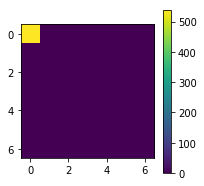

In [893]:
plot_gr(pcr.to_graph(7), s = 3)

In [762]:
pcr.glue_f_to_b(2,3,0,2)

In [763]:
pcr.glue_b_to_f(1,4, 2,1)

In [688]:
if bj > 0 and self.bp.p[bi][bj - 1] == -1:
    copy_part = self.fp.p[fi][:fj][self.fp.p[fi][:fj] != -1][fj - bj:fj]
    self.fp.p[bi][bj - copy_part.shape[0]:bj] = copy_part

NameError: name 'bj' is not defined

In [641]:
pcr.print_glue_points()

1 2 ;  0 2 ;  0 4
2 1 ;  0 4 ;  0 2
5 6 ;  1 2 ;  1 4
6 5 ;  1 4 ;  1 2


In [612]:
pcr._amplify()

1 17 ;  0 2 ;  3 4
3 22 ;  0 6 ;  4 4
6 6 ;  1 2 ;  1 2
7 8 ;  1 4 ;  1 6
8 7 ;  1 6 ;  1 4
17 1 ;  3 4 ;  0 2
22 3 ;  4 4 ;  0 6
27 27 ;  5 4 ;  5 4


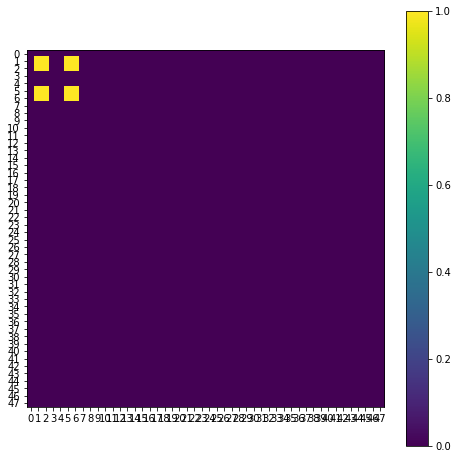

In [789]:
pcr._annealing()
plot_gr(pcr.comp_mat, s  = 8, all_ticks=1)

In [423]:
pcr._amplify()

0 (0, 1)
1 (0, 3)
2 (0, 5)
3 (1, 1)
4 (1, 3)
5 (1, 5)
5 (1, 5)
6 (2, 1)
8 (2, 5)
8 (2, 5)
8 (2, 5)
8 (2, 5)
12 (4, 1)
12 (4, 1)
12 (4, 1)
16 (5, 3)
16 (5, 3)
20 (6, 5)
20 (6, 5)


In [412]:
for a, b in zip(np.where(pcr.anneal == 1)[0], np.where(pcr.anneal == 1)[1]):
    print(a)

0
1
2
2
3
4
4
5
5
6
6
8
12
12
16
20
20
20


In [397]:
np.where(pcr.anneal == 1)[0]

array([ 0,  1,  2,  3,  4,  5,  5,  5,  6,  8,  8,  8, 12, 12, 12, 16, 20])

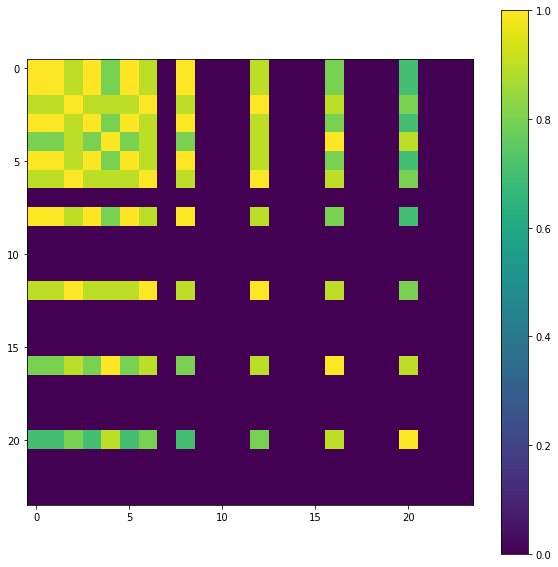

In [354]:
plot_gr(pcr.comp_mat)

In [101]:
p.bp

array([[ 0.,  0.,  0.,  0.,  1.,  1.,  2.,  0., -1.],
       [ 0.,  2.,  3.,  0.,  4.,  1., -1., -1., -1.],
       [ 1.,  0., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  1., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  2., -1., -1., -1., -1., -1., -1., -1.],
       [ 1.,  3., -1., -1., -1., -1., -1., -1., -1.]])

In [106]:
p.fp[:,1:]

array([[ 0.,  0.,  0.,  1.,  1.,  2.,  0., -1.],
       [ 2.,  3.,  0.,  4.,  1., -1., -1., -1.],
       [ 0., -1., -1., -1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1., -1., -1., -1., -1.],
       [ 2., -1., -1., -1., -1., -1., -1., -1.],
       [ 3., -1., -1., -1., -1., -1., -1., -1.]])

In [92]:
complementaries = np.zeros((24,24))

In [104]:
sh = p.bp[:,1:].shape

In [107]:
p.bp[:,1::2]

array([[ 0.,  0.,  1.,  0.],
       [ 2.,  0.,  1., -1.],
       [ 0., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [ 2., -1., -1., -1.],
       [ 3., -1., -1., -1.]])

In [ ]:
complementary_b_to_f = np.zeros

In [316]:
m = repeats_descr.mat

In [312]:
p.amplify(repeats_descr.mat, {})

[[0.  0.  0.  0. ]
 [1.  0.9 0.8 0.7]
 [1.  0.9 0.8 0.7]
 [0.9 1.  0.9 0.8]
 [1.  0.9 0.8 0.7]
 [0.8 0.9 1.  0.9]
 [1.  0.9 0.8 0.7]
 [0.9 1.  0.9 0.8]
 [0.9 1.  0.9 0.8]]


In [315]:
for x in p.p.flatten():
    print(x)

-1
-1
0
0
0
1
1
2
0
-1
2
3
0
4
1
-1
1
5
2
-1


In [317]:
m

array([[1. , 0.9, 0.8, 0.7],
       [0.9, 1. , 0.9, 0.8],
       [0.8, 0.9, 1. , 0.9],
       [0.7, 0.8, 0.9, 1. ]])

In [ ]:
np.random.choice(np.arange(12).reshape((3,4)), size = 4, p = 

In [267]:
def single_amplify(to_amplify, population=None, v = False):
    if population is None:
        population = [x for x in to_amplify]
    
    new = []
    for chain in to_amplify:
        start = np.random.randint(0, len(chain) - 1)
        stop = False
        end = np.random.randint(start + 1, len(chain))

        new_chain = []
        pointer = start

        while not stop:
            switch = np.random.rand() < SWITCH_PROB

            if v:
                print(chain, new_chain, switch)
            if switch:
                chain = population[np.random.randint(0, len(population))]
                pointer = np.random.randint(1, len(chain))

            if np.random.rand() < STOP_PROB:
                stop = True

            if len(new_chain) >= end - start:
                stop = True

            if pointer < len(chain):
                new_chain.append(chain[pointer])
            else:
                stop = True

            pointer += 1 

        if len(new_chain) > 2:
            new.append(new_chain)
    
    return [x[::-1] for x in new]

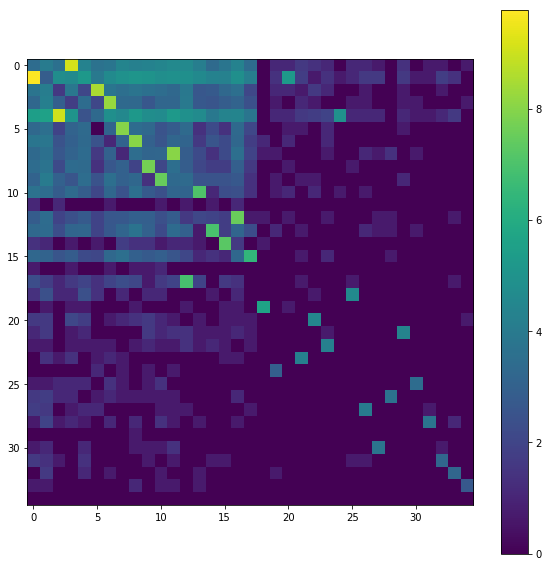

In [126]:
plot_gr(np.load("../../data/graphs/ES3_22.npy")[:35,:35], log = 1)

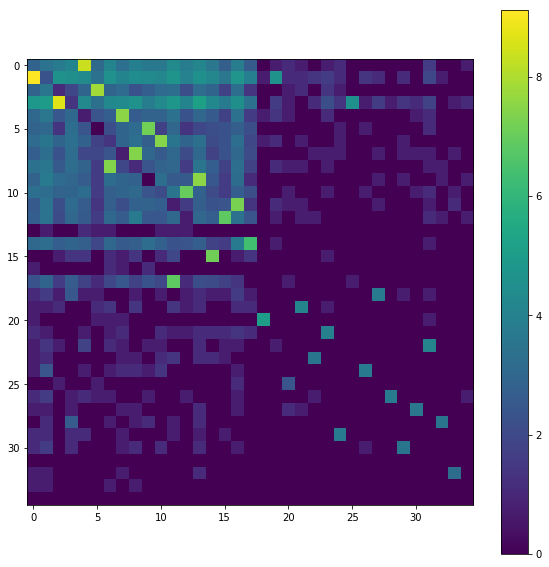

In [127]:
plot_gr(np.load("../../data/graphs/ES4_22.npy")[:35,:35], log = 1)